In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install fastai==1.0.61

In [3]:
# !pip install timm

In [4]:
# !pip show einops

In [5]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from PIL import Image
import os
from glob import glob
import cv2
from tqdm import tqdm
import multiprocessing as mp
import pandas as pd
from matplotlib import pyplot as plt
from torchvision import transforms
import timm

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F


In [6]:
from utils import interleave, de_interleave, show_batch, AverageMeter, show_grid, get_config
from learner import FixMatch, CoMatch, SupLearning
from dataset import get_data, GIDataset, get_transform
from build import build_model

In [7]:
# config = get_config('./configs/local_semisupervised_patho_mock.yaml')
# config = get_config('./configs/local_supervised.yaml')
config = get_config('./configs/local_reproduce.yaml')

In [8]:
df_anno = pd.read_csv(config['DATA']['ANNO'])
df_unanno = None
df_anno.head()

,file-name,class-name,split-index,image,target,is_valid
0,4bf58f1c-8233-41fc-9614-344e6d0fc351.jpg,impacted-stool,0,lower-gi-tract/quality-of-mucosal-views/impact...,7,False
1,9c3e5380-9621-4e74-b937-0c46f37e7ef3.jpg,impacted-stool,0,lower-gi-tract/quality-of-mucosal-views/impact...,7,False
2,cf3667be-0c86-4ce7-a0f3-721144b67230.jpg,impacted-stool,0,lower-gi-tract/quality-of-mucosal-views/impact...,7,False
3,8dbf6ead-8801-4a28-b811-62567dd2edb5.jpg,impacted-stool,0,lower-gi-tract/quality-of-mucosal-views/impact...,7,False
4,af09c241-1417-4a42-91ef-df86bab65f7c.jpg,impacted-stool,0,lower-gi-tract/quality-of-mucosal-views/impact...,7,False


Training mode: Full labeled supervised learning
Transforms mode: Re-produce paper
Transforms mode: Re-produce paper


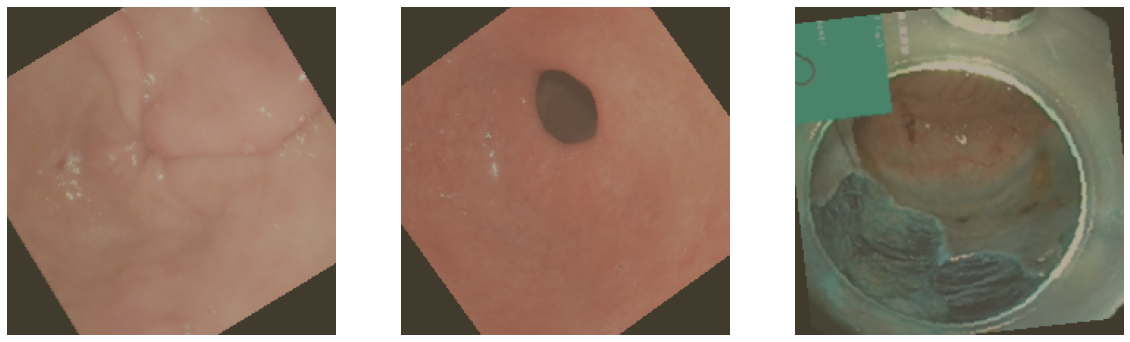

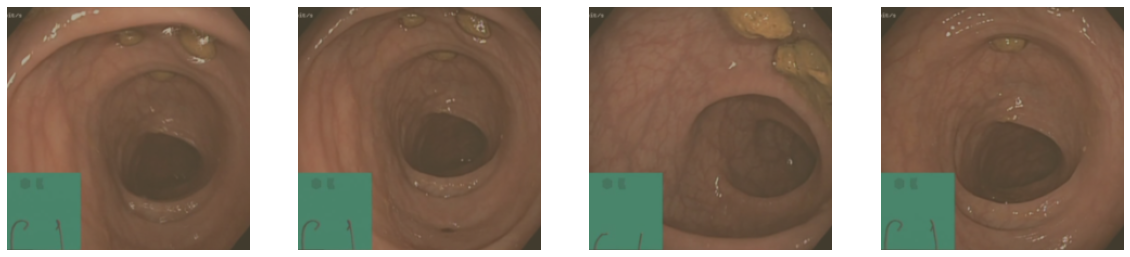

In [9]:
# train_dl, valid_dl = get_data(config, df_anno, df_unanno,is_full_sup = False, is_visual=True, type_semi = 'CoMatch')
train_dl, valid_dl = get_data(config, df_anno, df_unanno, is_visual=True, is_reprod =True)

In [10]:
model = build_model(config)

Selected model: densenet161 w/ Triplet


In [11]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [12]:
for param in model.parameters():
    param.requires_grad_(False)

In [13]:
model.model.classifier.requires_grad_(True)

Linear(in_features=2208, out_features=23, bias=False)

In [14]:
if config.TRAIN.IS_SSL:
    if config.MODEL.TYPE_SEMI == 'FixMatch':
        classifier = FixMatch(model = model,
                          opt_func=config['TRAIN']['OPT_NAME'], 
                          device = device)
    else:
        classifier = CoMatch(model = model,
                          opt_func=config['TRAIN']['OPT_NAME'], 
                          device = device)
else:
    classifier = SupLearning(model = model,
                          opt_func=config['TRAIN']['OPT_NAME'], 
                          device = device)
classifier.get_dataloader(train_dl, valid_dl)
classifier.get_config(config)

Training mode: Supervised Learning


In [15]:
# classifier.load_checkpoint('D:\\model\\endoscopy\\hyper_kvasir\\sup_resnet50\\05_31_2022_17_33_39_ce.pth')

In [16]:
classifier.fit()

Training epoch: 1 | Current LR: 0.000500


  0%|                                                                      | 0/167 [00:14<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# classifier.save_checkpoint('./')